# Naïve Bayes (Bernoulli) with SelectKBest: Parameter and Sampling Technique Exploration


In [ ]:
# Imports
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.naive_bayes import BernoulliNB

# File paths
train_file = "train.dat"

# Function to load and preprocess data from a given file path
def load_data(file_path):
    with open(file_path, "r") as fr:
        lines = fr.readlines()
    labels = [int(line[0]) for line in lines]
    docs = [re.sub(r'[^\w]', ' ', line[1:]).split() for line in lines]

    features = np.zeros((len(docs), 100001), dtype=int)  
    for i, doc in enumerate(docs):
        for value in doc:
            features[i, int(value)] = 1

    return features, np.array(labels)

# Function to print top models analysis
def print_top_models(metric_name, top_models):
    print(f"\n=== Top 5 Models by {metric_name} ===")
    for i, model in enumerate(top_models, start=1):
        print(f"\nRank {i}:")
        print(f"k: {model['k']}")
        print(f"Sampling Method: {model['sampling_name']}")
        print(f"Class Prior: {model['class_prior']}")  
        print(f"Validation Metrics:")
        print(f"Class 0 - Precision: {model['val_class_0_precision']:.4f}, "
                f"Recall: {model['val_class_0_recall']:.4f}, "
                f"F1: {model['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {model['val_class_1_precision']:.4f}, "
                f"Recall: {model['val_class_1_recall']:.4f}, "
                f"F1: {model['val_class_1_f1']:.4f}")
        print(f"Average F1 Score: {model['val_avg_f1']:.4f}")

        # Calculate and print relative improvement over baseline
        baseline = validation_results[0]  # assuming first configuration is baseline
        f1_improvement = ((model['val_avg_f1'] - baseline['val_avg_f1']) 
                          / baseline['val_avg_f1'] * 100)
        print(f"Improvement over baseline: {f1_improvement:+.2f}%")

# Load training data
train_features, train_labels = load_data(train_file)

# Initialize configurations
# Define sampling techniques
sampling_methods = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}

# List of class priors to try
priors_list = [
    [0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.5, 0.5], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9]
]

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Print detailed dataset information
train_counts = Counter(train_labels)
print("\n=== Dataset Information ===")
print(f"Training Set - Total: {len(train_labels)}, "
        f"Class 0: {train_counts.get(0, 0)}, Class 1: {train_counts.get(1, 0)}")
print(f"Class Distribution - Class 0: {train_counts.get(0, 0) / len(train_labels):.2%}, "
        f"Class 1: {train_counts.get(1, 0) / len(train_labels):.2%}")
print(f"Feature Space Dimension: {train_features.shape[1]}")

# Store validation results for model selection
validation_results = []

# Loop over a range of `k` values for SelectKBest
for k in range(11, 1001):
    print(f"\n=== Evaluating with k={k} ===")
    print(f"Feature Selection: Reducing from {train_features.shape[1]} to {k} features")
    fold_results = []

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_features, train_labels), 1):
        X_train, X_val = train_features[train_idx], train_features[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]

        print(f"\n--- Fold {fold}/5 ---")
        fold_train_dist = Counter(y_train)
        fold_val_dist = Counter(y_val)
        print(f"Training Split - Class 0: {fold_train_dist.get(0, 0)} "
              f"({fold_train_dist.get(0, 0) / len(y_train):.2%}), "
              f"Class 1: {fold_train_dist.get(1, 0)} "
              f"({fold_train_dist.get(1, 0) / len(y_train):.2%})")
        print(f"Validation Split - Class 0: {fold_val_dist.get(0, 0)} "
              f"({fold_val_dist.get(0, 0) / len(y_val):.2%}), "
              f"Class 1: {fold_val_dist.get(1, 0)} "
              f"({fold_val_dist.get(1, 0) / len(y_val):.2%})")

        # SelectKBest feature selection
        kbest = SelectKBest(chi2, k=k)
        X_train_selected = kbest.fit_transform(X_train, y_train)
        X_val_selected = kbest.transform(X_val)
        print(f"Features selected: {k}/{train_features.shape[1]}")

        for sampling_name, sampler in sampling_methods.items():
            print(f"\nApplying {sampling_name}...")
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, y_train)

            # Print resampled distribution
            resampled_dist = Counter(y_train_resampled)
            print(f"After {sampling_name} - Class 0: {resampled_dist.get(0, 0)} "
                  f"({resampled_dist.get(0, 0) / len(y_train_resampled):.2%}), "
                  f"Class 1: {resampled_dist.get(1, 0)} "
                  f"({resampled_dist.get(1, 0) / len(y_train_resampled):.2%})")

            for class_prior in priors_list:
                print(f"\nTrying class prior: {class_prior}")
                model = BernoulliNB(class_prior=class_prior)
                model.fit(X_train_resampled, y_train_resampled)

                # Predict on validation set
                y_val_pred = model.predict(X_val_selected)

                # Print validation predictions distribution
                val_dist = Counter(y_val_pred)
                print(f"Validation Predictions - Class 0: {val_dist.get(0, 0)} "
                      f"({val_dist.get(0, 0) / len(y_val_pred):.2%}), "
                      f"Class 1: {val_dist.get(1, 0)} "
                      f"({val_dist.get(1, 0) / len(y_val_pred):.2%})")

                # Calculate validation metrics
                precision = precision_score(y_val, y_val_pred, average=None, zero_division=0)
                recall = recall_score(y_val, y_val_pred, average=None, zero_division=0)
                f1 = f1_score(y_val, y_val_pred, average=None, zero_division=0)
                avg_f1 = np.mean(f1)

                print("Validation Metrics:")
                print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
                print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
                print(f"Average F1: {avg_f1:.4f}")

                # Append results
                fold_results.append({
                    'k': k,
                    'sampling_name': sampling_name,
                    'class_prior': class_prior,
                    'fold': fold,
                    'val_class_0_precision': precision[0],
                    'val_class_1_precision': precision[1],
                    'val_class_0_recall': recall[0],
                    'val_class_1_recall': recall[1],
                    'val_class_0_f1': f1[0],
                    'val_class_1_f1': f1[1],
                    'val_avg_f1': avg_f1
                })

    print("\n=== Aggregating Fold Results ===")
    # Aggregate metrics across folds for each configuration
    unique_configs = set(
        (r['k'], r['sampling_name'], str(r['class_prior'])) for r in fold_results
    )

    for k, sampling_name, class_prior_str in unique_configs:
        config_results = [
            r for r in fold_results 
            if r['k'] == k and 
            r['sampling_name'] == sampling_name and 
            str(r['class_prior']) == class_prior_str
        ]

        print(f"\nConfiguration: k={k}, Sampling={sampling_name}, Prior={class_prior_str}")

        avg_metrics = {
            'k': k,
            'sampling_name': sampling_name,
            'class_prior': eval(class_prior_str),
            'val_class_0_precision': np.mean([r['val_class_0_precision'] for r in config_results]),
            'val_class_1_precision': np.mean([r['val_class_1_precision'] for r in config_results]),
            'val_class_0_recall': np.mean([r['val_class_0_recall'] for r in config_results]),
            'val_class_1_recall': np.mean([r['val_class_1_recall'] for r in config_results]),
            'val_class_0_f1': np.mean([r['val_class_0_f1'] for r in config_results]),
            'val_class_1_f1': np.mean([r['val_class_1_f1'] for r in config_results]),
            'val_avg_f1': np.mean([r['val_avg_f1'] for r in config_results])
        }

        print(f"Average Metrics Across Folds:")
        print(f"Class 0 - Precision: {avg_metrics['val_class_0_precision']:.4f}, "
              f"Recall: {avg_metrics['val_class_0_recall']:.4f}, "
              f"F1: {avg_metrics['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {avg_metrics['val_class_1_precision']:.4f}, "
              f"Recall: {avg_metrics['val_class_1_recall']:.4f}, "
              f"F1: {avg_metrics['val_class_1_f1']:.4f}")
        print(f"Average F1: {avg_metrics['val_avg_f1']:.4f}")

        validation_results.append(avg_metrics)



# Identify the best configuration
best_config = max(validation_results, key=lambda x: x['val_avg_f1'])
print("\n=== Best Configuration from Cross-Validation ===")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Prior: {best_config['class_prior']}") 
print(f"Validation Metrics:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Average F1: {best_config['val_avg_f1']:.4f}")

print("\n=== Training Final Model with Best Configuration ===")
# Final model training
final_kbest = SelectKBest(chi2, k=best_config['k'])
X_train_selected = final_kbest.fit_transform(train_features, train_labels)

# Apply sampling based on the best configuration
final_sampler = sampling_methods[best_config['sampling_name']]
X_train_resampled, y_train_resampled = final_sampler.fit_resample(X_train_selected, train_labels)
resampled_dist = Counter(y_train_resampled)
print(f"Final Training Distribution After Sampling:")
print(f"Class 0: {resampled_dist[0]} ({resampled_dist[0]/len(y_train_resampled):.2%})")
print(f"Class 1: {resampled_dist[1]} ({resampled_dist[1]/len(y_train_resampled):.2%})")

# Train final model
final_model = BernoulliNB(class_prior=best_config['class_prior'])
final_model.fit(X_train_resampled, y_train_resampled)

# Sort the results based on different metrics
top_precision = sorted(validation_results, 
                        key=lambda x: x['val_class_1_precision'], 
                        reverse=True)[:5]
top_recall = sorted(validation_results, 
                    key=lambda x: x['val_class_1_recall'], 
                    reverse=True)[:5]
top_f1_class_1 = sorted(validation_results, 
                        key=lambda x: x['val_class_1_f1'], 
                        reverse=True)[:5]
top_avg_f1 = sorted(validation_results, 
                    key=lambda x: x['val_avg_f1'], 
                    reverse=True)[:5]

print("\n=== Top Configurations Analysis ===")
print_top_models("Class 1 Precision", top_precision)
print_top_models("Class 1 Recall", top_recall)
print_top_models("Class 1 F1 Score", top_f1_class_1)
print_top_models("Overall Average F1 Score", top_avg_f1)

# Print overlap analysis
print("\n=== Configuration Overlap Analysis ===")
print("Models appearing in multiple top 5 lists:")

# Prepare metric configurations
metric_configs = {
    "Precision": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_precision},  
    "Recall": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_recall},  
    "F1": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_f1_class_1}, 
    "Avg F1": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_avg_f1} 
}

# Union of all configurations
all_top_configs = set.union(*metric_configs.values())

for config in all_top_configs:
    appearances = []
    for metric, configs in metric_configs.items():
        if config in configs:
            appearances.append(metric)
    if len(appearances) > 1:
        k, sampling, prior = config
        print(f"\nConfiguration:")
        print(f"k: {k}")
        print(f"Sampling: {sampling}")
        print(f"Class Prior: {eval(prior)}")  
        print(f"Appears in: {', '.join(appearances)}")

# Feature Selection Analysis
print("\n=== Feature Selection Analysis ===")
print("Most common k values in top configurations:")
all_top_k = ([m['k'] for m in top_precision] + 
             [m['k'] for m in top_recall] + 
             [m['k'] for m in top_f1_class_1] + 
             [m['k'] for m in top_avg_f1])
k_counter = Counter(all_top_k)
for k, count in k_counter.most_common():
    print(f"k={k}: appears {count} times")

# Sampling Method Analysis
print("\n=== Sampling Method Analysis ===")
print("Most common sampling methods in top configurations:")
all_top_sampling = ([m['sampling_name'] for m in top_precision] + 
                    [m['sampling_name'] for m in top_recall] + 
                    [m['sampling_name'] for m in top_f1_class_1] + 
                    [m['sampling_name'] for m in top_avg_f1])
sampling_counter = Counter(all_top_sampling)
for sampling, count in sampling_counter.most_common():
    print(f"{sampling}: appears {count} times")

# Class Prior Analysis
print("\n=== Class Prior Analysis ===")
print("Most common class priors in top configurations:")
all_top_priors = ([str(m['class_prior']) for m in top_precision] + 
                  [str(m['class_prior']) for m in top_recall] + 
                  [str(m['class_prior']) for m in top_f1_class_1] + 
                  [str(m['class_prior']) for m in top_avg_f1])
prior_counter = Counter(all_top_priors)
for prior, count in prior_counter.most_common():
    print(f"{prior}: appears {count} times")

# Get best 3 models by validation F1
top_3_validation = sorted(validation_results, 
                          key=lambda x: x['val_avg_f1'], 
                          reverse=True)[:3]

# Print top 3 models by validation F1 score (BernoulliNB setup)
print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Prior: {model['class_prior']}")  
    print(f"Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Average F1: {model['val_avg_f1']:.4f}")


# Test performance with BernoulliNB setup
test_results = []
for config in validation_results:
    # Apply feature selection
    kbest = SelectKBest(chi2, k=config['k'])
    X_train_selected = kbest.fit_transform(train_features, train_labels)

    sampler = sampling_methods[config['sampling_name']]
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, train_labels)

    # Use BernoulliNB for final model
    model = BernoulliNB(class_prior=config['class_prior'])  
    model.fit(X_train_resampled, y_train_resampled)

# Print top 3 models by validation F1 score (BernoulliNB setup)
top_3_validation = sorted(validation_results, 
                          key=lambda x: x['val_avg_f1'], 
                          reverse=True)[:3]

print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"Model: BernoulliNB")  
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Prior: {model['class_prior']}") 
    print(f"Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Average F1: {model['val_avg_f1']:.4f}")

# Overlap analysis between top validation and test models
print("\n=== Overlap Analysis between Top 3 Validation and Test Models ===")
validation_configs = {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_3_validation}

print("\nConfigurations appearing in both top 3 lists:")
for k, sampling, prior in validation_configs:
    print(f"k: {k}")
    print(f"Sampling Method: {sampling}")
    print(f"Class Prior: {eval(prior)}")  

# Final summary
print("\n=== Final Summary ===")
print("Best Configuration Details:")
print("Model: BernoulliNB with SelectKBest")  
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Prior: {best_config['class_prior']}")  

print("\nPerformance Metrics:")
print("Validation Performance:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Validation - Avg F1: {best_config['val_avg_f1']:.4f}")


# Naïve Bayes (Bernoulli) with Truncated SVD and SelectKBest: Parameter and Sampling Technique Exploration

In [ ]:
# Imports
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.naive_bayes import BernoulliNB

# File paths
train_file = "train.dat"

# Function to load and preprocess data from a given file path
def load_data(file_path):
    with open(file_path, "r") as fr:
        lines = fr.readlines()
    labels = [int(line[0]) for line in lines]
    docs = [re.sub(r'[^\w]', ' ', line[1:]).split() for line in lines]

    features = np.zeros((len(docs), 100001), dtype=int)  
    for i, doc in enumerate(docs):
        for value in doc:
            features[i, int(value)] = 1

    return features, np.array(labels)

# Function to print top models analysis
def print_top_models(metric_name, top_models):
    print(f"\n=== Top 5 Models by {metric_name} ===")
    for i, model in enumerate(top_models, start=1):
        print(f"\nRank {i}:")
        print(f"k: {model['k']}")
        print(f"Sampling Method: {model['sampling_name']}")
        print(f"Class Prior: {model['class_prior']}")  
        print(f"Validation Metrics:")
        print(f"Class 0 - Precision: {model['val_class_0_precision']:.4f}, "
                f"Recall: {model['val_class_0_recall']:.4f}, "
                f"F1: {model['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {model['val_class_1_precision']:.4f}, "
                f"Recall: {model['val_class_1_recall']:.4f}, "
                f"F1: {model['val_class_1_f1']:.4f}")
        print(f"Average F1 Score: {model['val_avg_f1']:.4f}")

        # Calculate and print relative improvement over baseline
        baseline = validation_results[0]  # assuming first configuration is baseline
        f1_improvement = ((model['val_avg_f1'] - baseline['val_avg_f1']) 
                          / baseline['val_avg_f1'] * 100)
        print(f"Improvement over baseline: {f1_improvement:+.2f}%")

# Load training data
train_features, train_labels = load_data(train_file)

# Initialize configurations
# Define sampling techniques
sampling_methods = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}

# List of class priors to try
priors_list = [
    [0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.5, 0.5], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9]
]

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Print detailed dataset information
train_counts = Counter(train_labels)
print("\n=== Dataset Information ===")
print(f"Training Set - Total: {len(train_labels)}, "
        f"Class 0: {train_counts.get(0, 0)}, Class 1: {train_counts.get(1, 0)}")
print(f"Class Distribution - Class 0: {train_counts.get(0, 0) / len(train_labels):.2%}, "
        f"Class 1: {train_counts.get(1, 0) / len(train_labels):.2%}")
print(f"Feature Space Dimension: {train_features.shape[1]}")

# Store validation results for model selection
validation_results = []

# Loop over a range of `k` values for SelectKBest
for k in range(11,1001):
    print(f"\n=== Evaluating with k={k} ===")
    print(f"Feature Selection: Reducing from {train_features.shape[1]} to {k} features")
    fold_results = []

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_features, train_labels), 1):
        X_train, X_val = train_features[train_idx], train_features[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]

        print(f"\n--- Fold {fold}/5 ---")
        fold_train_dist = Counter(y_train)
        fold_val_dist = Counter(y_val)
        print(f"Training Split - Class 0: {fold_train_dist.get(0, 0)} "
              f"({fold_train_dist.get(0, 0) / len(y_train):.2%}), "
              f"Class 1: {fold_train_dist.get(1, 0)} "
              f"({fold_train_dist.get(1, 0) / len(y_train):.2%})")
        print(f"Validation Split - Class 0: {fold_val_dist.get(0, 0)} "
              f"({fold_val_dist.get(0, 0) / len(y_val):.2%}), "
              f"Class 1: {fold_val_dist.get(1, 0)} "
              f"({fold_val_dist.get(1, 0) / len(y_val):.2%})")

        # Apply SelectKBest to reduce features
        kbest = SelectKBest(chi2, k=k)
        X_train_selected_temp = kbest.fit_transform(X_train, y_train)
        X_val_selected_temp = kbest.transform(X_val)

        # Apply TruncatedSVD after SelectKBest
        svd = TruncatedSVD(n_components=min(k, X_train_selected_temp.shape[1]))
        X_train_selected = svd.fit_transform(X_train_selected_temp)
        X_val_selected = svd.transform(X_val_selected_temp)

        print(f"Features selected: {k}")
        print(f"Explained variance ratio after SVD: {sum(svd.explained_variance_ratio_):.4f}")


        for sampling_name, sampler in sampling_methods.items():
            print(f"\nApplying {sampling_name}...")
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, y_train)

            # Print resampled distribution
            resampled_dist = Counter(y_train_resampled)
            print(f"After {sampling_name} - Class 0: {resampled_dist.get(0, 0)} "
                  f"({resampled_dist.get(0, 0) / len(y_train_resampled):.2%}), "
                  f"Class 1: {resampled_dist.get(1, 0)} "
                  f"({resampled_dist.get(1, 0) / len(y_train_resampled):.2%})")

            for class_prior in priors_list:
                # Check if the number of priors matches the number of unique classes
                if len(class_prior) != len(np.unique(y_train_resampled)):
                    print(f"Skipping class_prior {class_prior} as it doesn't match the number of classes.")
                    continue  # Skip this iteration if the prior length is incorrect

                print(f"\nTrying class prior: {class_prior}")
                model = BernoulliNB(class_prior=class_prior)
                model.fit(X_train_resampled, y_train_resampled)

                # Predict on validation set
                y_val_pred = model.predict(X_val_selected)

                # Print validation predictions distribution
                val_dist = Counter(y_val_pred)
                print(f"Validation Predictions - Class 0: {val_dist.get(0, 0)} "
                    f"({val_dist.get(0, 0) / len(y_val_pred):.2%}), "
                    f"Class 1: {val_dist.get(1, 0)} "
                    f"({val_dist.get(1, 0) / len(y_val_pred):.2%})")

                # Calculate validation metrics
                precision = precision_score(y_val, y_val_pred, average=None, zero_division=0)
                recall = recall_score(y_val, y_val_pred, average=None, zero_division=0)
                f1 = f1_score(y_val, y_val_pred, average=None, zero_division=0)
                avg_f1 = np.mean(f1)

                print("Validation Metrics:")
                print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
                print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
                print(f"Average F1: {avg_f1:.4f}")

                # Append results
                fold_results.append({
                    'k': k,
                    'sampling_name': sampling_name,
                    'class_prior': class_prior,
                    'fold': fold,
                    'val_class_0_precision': precision[0],
                    'val_class_1_precision': precision[1],
                    'val_class_0_recall': recall[0],
                    'val_class_1_recall': recall[1],
                    'val_class_0_f1': f1[0],
                    'val_class_1_f1': f1[1],
                    'val_avg_f1': avg_f1
                })


    print("\n=== Aggregating Fold Results ===")
    # Aggregate metrics across folds for each configuration
    unique_configs = set(
        (r['k'], r['sampling_name'], str(r['class_prior'])) for r in fold_results
    )

    for k, sampling_name, class_prior_str in unique_configs:
        config_results = [
            r for r in fold_results 
            if r['k'] == k and 
            r['sampling_name'] == sampling_name and 
            str(r['class_prior']) == class_prior_str
        ]

        print(f"\nConfiguration: k={k}, Sampling={sampling_name}, Prior={class_prior_str}")

        avg_metrics = {
            'k': k,
            'sampling_name': sampling_name,
            'class_prior': eval(class_prior_str),
            'val_class_0_precision': np.mean([r['val_class_0_precision'] for r in config_results]),
            'val_class_1_precision': np.mean([r['val_class_1_precision'] for r in config_results]),
            'val_class_0_recall': np.mean([r['val_class_0_recall'] for r in config_results]),
            'val_class_1_recall': np.mean([r['val_class_1_recall'] for r in config_results]),
            'val_class_0_f1': np.mean([r['val_class_0_f1'] for r in config_results]),
            'val_class_1_f1': np.mean([r['val_class_1_f1'] for r in config_results]),
            'val_avg_f1': np.mean([r['val_avg_f1'] for r in config_results])
        }

        print(f"Average Metrics Across Folds:")
        print(f"Class 0 - Precision: {avg_metrics['val_class_0_precision']:.4f}, "
              f"Recall: {avg_metrics['val_class_0_recall']:.4f}, "
              f"F1: {avg_metrics['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {avg_metrics['val_class_1_precision']:.4f}, "
              f"Recall: {avg_metrics['val_class_1_recall']:.4f}, "
              f"F1: {avg_metrics['val_class_1_f1']:.4f}")
        print(f"Average F1: {avg_metrics['val_avg_f1']:.4f}")

        validation_results.append(avg_metrics)



# Identify the best configuration
best_config = max(validation_results, key=lambda x: x['val_avg_f1'])
print("\n=== Best Configuration from Cross-Validation ===")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Prior: {best_config['class_prior']}") 
print(f"Validation Metrics:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Average F1: {best_config['val_avg_f1']:.4f}")

print("\n=== Training Final Model with Best Configuration ===")

# Apply SelectKBest to reduce features on the entire training set
final_kbest = SelectKBest(chi2, k=best_config['k'])
X_train_selected_temp = final_kbest.fit_transform(train_features, train_labels)

# Apply TruncatedSVD after SelectKBest
final_svd = TruncatedSVD(n_components=best_config['k'])
X_train_selected = final_svd.fit_transform(X_train_selected_temp)

print(f"Explained variance ratio after SVD: {sum(final_svd.explained_variance_ratio_):.4f}")


# Apply sampling based on the best configuration
final_sampler = sampling_methods[best_config['sampling_name']]
X_train_resampled, y_train_resampled = final_sampler.fit_resample(X_train_selected, train_labels)
resampled_dist = Counter(y_train_resampled)
print(f"Final Training Distribution After Sampling:")
print(f"Class 0: {resampled_dist[0]} ({resampled_dist[0]/len(y_train_resampled):.2%})")
print(f"Class 1: {resampled_dist[1]} ({resampled_dist[1]/len(y_train_resampled):.2%})")

# Train final model
final_model = BernoulliNB(class_prior=best_config['class_prior'])
final_model.fit(X_train_resampled, y_train_resampled)

# Sort the results based on different metrics
top_precision = sorted(validation_results, 
                        key=lambda x: x['val_class_1_precision'], 
                        reverse=True)[:5]
top_recall = sorted(validation_results, 
                    key=lambda x: x['val_class_1_recall'], 
                    reverse=True)[:5]
top_f1_class_1 = sorted(validation_results, 
                        key=lambda x: x['val_class_1_f1'], 
                        reverse=True)[:5]
top_avg_f1 = sorted(validation_results, 
                    key=lambda x: x['val_avg_f1'], 
                    reverse=True)[:5]

print("\n=== Top Configurations Analysis ===")
print_top_models("Class 1 Precision", top_precision)
print_top_models("Class 1 Recall", top_recall)
print_top_models("Class 1 F1 Score", top_f1_class_1)
print_top_models("Overall Average F1 Score", top_avg_f1)

# Print overlap analysis
print("\n=== Configuration Overlap Analysis ===")
print("Models appearing in multiple top 5 lists:")

# Prepare metric configurations
metric_configs = {
    "Precision": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_precision},  
    "Recall": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_recall},  
    "F1": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_f1_class_1}, 
    "Avg F1": {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_avg_f1} 
}

# Union of all configurations
all_top_configs = set.union(*metric_configs.values())

for config in all_top_configs:
    appearances = []
    for metric, configs in metric_configs.items():
        if config in configs:
            appearances.append(metric)
    if len(appearances) > 1:
        k, sampling, prior = config
        print(f"\nConfiguration:")
        print(f"k: {k}")
        print(f"Sampling: {sampling}")
        print(f"Class Prior: {eval(prior)}")  
        print(f"Appears in: {', '.join(appearances)}")

# Feature Selection Analysis
print("\n=== Feature Selection Analysis ===")
print("Most common k values in top configurations:")
all_top_k = ([m['k'] for m in top_precision] + 
             [m['k'] for m in top_recall] + 
             [m['k'] for m in top_f1_class_1] + 
             [m['k'] for m in top_avg_f1])
k_counter = Counter(all_top_k)
for k, count in k_counter.most_common():
    print(f"k={k}: appears {count} times")

# Sampling Method Analysis
print("\n=== Sampling Method Analysis ===")
print("Most common sampling methods in top configurations:")
all_top_sampling = ([m['sampling_name'] for m in top_precision] + 
                    [m['sampling_name'] for m in top_recall] + 
                    [m['sampling_name'] for m in top_f1_class_1] + 
                    [m['sampling_name'] for m in top_avg_f1])
sampling_counter = Counter(all_top_sampling)
for sampling, count in sampling_counter.most_common():
    print(f"{sampling}: appears {count} times")

# Class Prior Analysis
print("\n=== Class Prior Analysis ===")
print("Most common class priors in top configurations:")
all_top_priors = ([str(m['class_prior']) for m in top_precision] + 
                  [str(m['class_prior']) for m in top_recall] + 
                  [str(m['class_prior']) for m in top_f1_class_1] + 
                  [str(m['class_prior']) for m in top_avg_f1])
prior_counter = Counter(all_top_priors)
for prior, count in prior_counter.most_common():
    print(f"{prior}: appears {count} times")

# Get best 3 models by validation F1
top_3_validation = sorted(validation_results, 
                          key=lambda x: x['val_avg_f1'], 
                          reverse=True)[:3]

# Print top 3 models by validation F1 score (BernoulliNB setup)
print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Prior: {model['class_prior']}")  
    print(f"Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Average F1: {model['val_avg_f1']:.4f}")


# Test performance with BernoulliNB setup
test_results = []
for config in validation_results:
    # Apply feature selection
    kbest = SelectKBest(chi2, k=config['k'])
    X_train_selected = kbest.fit_transform(train_features, train_labels)

    sampler = sampling_methods[config['sampling_name']]
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, train_labels)

    # Use BernoulliNB for final model
    model = BernoulliNB(class_prior=config['class_prior'])  
    model.fit(X_train_resampled, y_train_resampled)

# Print top 3 models by validation F1 score (BernoulliNB setup)
top_3_validation = sorted(validation_results, 
                          key=lambda x: x['val_avg_f1'], 
                          reverse=True)[:3]

print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"Model: BernoulliNB")  
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Prior: {model['class_prior']}") 
    print(f"Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Average F1: {model['val_avg_f1']:.4f}")

# Overlap analysis between top validation and test models
print("\n=== Overlap Analysis between Top 3 Validation and Test Models ===")
validation_configs = {(m['k'], m['sampling_name'], str(m['class_prior'])) for m in top_3_validation}

print("\nConfigurations appearing in both top 3 lists:")
for k, sampling, prior in validation_configs:
    print(f"k: {k}")
    print(f"Sampling Method: {sampling}")
    print(f"Class Prior: {eval(prior)}")  

# Final summary
print("\n=== Final Summary ===")
print("Best Configuration Details:")
print("Model: BernoulliNB with SelectKBest")  
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Prior: {best_config['class_prior']}")  

print("\nPerformance Metrics:")
print("Validation Performance:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Validation - Avg F1: {best_config['val_avg_f1']:.4f}")


# Decision Tree with SelectKBest: Parameter and Sampling Technique Exploration

In [ ]:
# Imports
import re
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

# File path
train_file = "train.dat"

# Function to load and preprocess data from a given file path
def load_data(file_path):
    with open(file_path, "r") as fr:
        lines = fr.readlines()
    labels = [int(line[0]) for line in lines]
    docs = [re.sub(r'[^\w]', ' ', line[1:]).split() for line in lines]

    features = []
    for doc in docs:
        line = [0] * 100001
        for value in doc:
            line[int(value)] = 1
        features.append(line)

    return np.array(features), np.array(labels)

# Function to print top models analysis
def print_top_models(metric_name, top_models):
    print(f"\n=== Top 5 Models by {metric_name} ===")
    for i, model in enumerate(top_models, start=1):
        print(f"\nRank {i}:")
        print(f"k: {model['k']}")
        print(f"Sampling Method: {model['sampling_name']}")
        print(f"Class Weights: {model['class_weight']}")
        print(f"Validation Metrics:")
        print(f"Class 0 - Precision: {model['val_class_0_precision']:.4f}, "
              f"Recall: {model['val_class_0_recall']:.4f}, "
              f"F1: {model['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {model['val_class_1_precision']:.4f}, "
              f"Recall: {model['val_class_1_recall']:.4f}, "
              f"F1: {model['val_class_1_f1']:.4f}")
        print(f"Average F1 Score: {model['val_avg_f1']:.4f}")

        # Calculate and print relative improvement over baseline
        baseline = validation_results[0]  # assuming first configuration is baseline
        f1_improvement = ((model['val_avg_f1'] - baseline['val_avg_f1']) 
                         / baseline['val_avg_f1'] * 100)
        print(f"Improvement over baseline: {f1_improvement:+.2f}%")

# Load training data
train_features, train_labels = load_data(train_file)

# Initialize configurations
# Define sampling techniques
sampling_methods = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}

# Define class weights to handle class imbalance
class_weight_options = [
    {0: 0.9, 1: 0.1},
    {0: 0.8, 1: 0.2},
    {0: 0.7, 1: 0.3},
    {0: 0.5, 1: 0.5},
    {0: 0.3, 1: 0.7},
    {0: 0.2, 1: 0.8},
    {0: 0.1, 1: 0.9}
]


# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Print detailed dataset information
train_counts = Counter(train_labels)
print("\n=== Dataset Information ===")
print(f"Training Set - Total: {len(train_labels)}, Class 0: {train_counts[0]}, Class 1: {train_counts[1]}")
print(f"Class Distribution - Class 0: {train_counts[0] / len(train_labels):.2%}, Class 1: {train_counts[1] / len(train_labels):.2%}")
print(f"Feature Space Dimension: {train_features.shape[1]}")

# Store validation results for model selection
validation_results = []

# Loop over a range of `k` values for SelectKBest
for k in range(11,1001):
    print(f"\n=== Evaluating with k={k} ===")
    print(f"Feature Selection: Reducing from {train_features.shape[1]} to {k} features")
    fold_results = []

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_features, train_labels), 1):
        X_train, X_val = train_features[train_idx], train_features[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]

        print(f"\n--- Fold {fold}/5 ---")
        fold_train_dist = Counter(y_train)
        fold_val_dist = Counter(y_val)
        print(f"Training Split - Class 0: {fold_train_dist[0]} ({fold_train_dist[0] / len(y_train):.2%}), "
              f"Class 1: {fold_train_dist[1]} ({fold_train_dist[1] / len(y_train):.2%})")
        print(f"Validation Split - Class 0: {fold_val_dist[0]} ({fold_val_dist[0] / len(y_val):.2%}), "
              f"Class 1: {fold_val_dist[1]} ({fold_val_dist[1] / len(y_val):.2%})")

        # Apply SelectKBest on the training data only
        kbest = SelectKBest(chi2, k=k)
        X_train_selected = kbest.fit_transform(X_train, y_train)
        X_val_selected = kbest.transform(X_val)
        print(f"Features selected: {k}/{train_features.shape[1]}")

        for sampling_name, sampler in sampling_methods.items():
            print(f"\nApplying {sampling_name}...")
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, y_train)
            
            # Print resampled distribution
            resampled_dist = Counter(y_train_resampled)
            print(f"After {sampling_name} - Class 0: {resampled_dist[0]} ({resampled_dist[0] / len(y_train_resampled):.2%}), "
                  f"Class 1: {resampled_dist[1]} ({resampled_dist[1] / len(y_train_resampled):.2%})")

            for class_weight in class_weight_options:
                print(f"\nTrying class weights: {class_weight}")
                model = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
                model.fit(X_train_resampled, y_train_resampled)
                
                # Print tree information
                print(f"Tree Depth: {model.get_depth()}, Nodes: {model.get_n_leaves()}")
                
                y_val_pred = model.predict(X_val_selected)
                val_dist = Counter(y_val_pred)
                print(f"Validation Predictions - Class 0: {val_dist[0]} ({val_dist[0] / len(y_val_pred):.2%}), "
                      f"Class 1: {val_dist[1]} ({val_dist[1] / len(y_val_pred):.2%})")

                # Calculate validation metrics
                precision = precision_score(y_val, y_val_pred, average=None)
                recall = recall_score(y_val, y_val_pred, average=None)
                f1 = f1_score(y_val, y_val_pred, average=None)
                avg_f1 = np.mean(f1)

                print("Validation Metrics:")
                print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
                print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
                print(f"Average F1: {avg_f1:.4f}")

                fold_results.append({
                    'k': k, 'sampling_name': sampling_name,
                    'class_weight': class_weight, 'fold': fold,
                    'val_class_0_precision': precision[0], 'val_class_1_precision': precision[1],
                    'val_class_0_recall': recall[0], 'val_class_1_recall': recall[1],
                    'val_class_0_f1': f1[0], 'val_class_1_f1': f1[1], 'val_avg_f1': avg_f1
                })


print("\n=== Aggregating Fold Results ===")
# Aggregate metrics across folds for each configuration
unique_configs = set((r['k'], r['sampling_name'], str(r['class_weight'])) for r in fold_results)
for k, sampling_name, class_weight_str in unique_configs:
    config_results = [r for r in fold_results 
                     if r['k'] == k and 
                     r['sampling_name'] == sampling_name and 
                     str(r['class_weight']) == class_weight_str]
    
    print(f"\nConfiguration: k={k}, Sampling={sampling_name}, Weights={class_weight_str}")
    avg_metrics = {
        'k': k, 'sampling_name': sampling_name, 'class_weight': eval(class_weight_str),
        'val_class_0_precision': np.mean([r['val_class_0_precision'] for r in config_results]),
        'val_class_1_precision': np.mean([r['val_class_1_precision'] for r in config_results]),
        'val_class_0_recall': np.mean([r['val_class_0_recall'] for r in config_results]),
        'val_class_1_recall': np.mean([r['val_class_1_recall'] for r in config_results]),
        'val_class_0_f1': np.mean([r['val_class_0_f1'] for r in config_results]),
        'val_class_1_f1': np.mean([r['val_class_1_f1'] for r in config_results]),
        'val_avg_f1': np.mean([r['val_avg_f1'] for r in config_results])
    }
    print(f"Average Metrics Across Folds:")
    print(f"Class 0 - Precision: {avg_metrics['val_class_0_precision']:.4f}, "
          f"Recall: {avg_metrics['val_class_0_recall']:.4f}, "
          f"F1: {avg_metrics['val_class_0_f1']:.4f}")
    print(f"Class 1 - Precision: {avg_metrics['val_class_1_precision']:.4f}, "
          f"Recall: {avg_metrics['val_class_1_recall']:.4f}, "
          f"F1: {avg_metrics['val_class_1_f1']:.4f}")
    print(f"Average F1: {avg_metrics['val_avg_f1']:.4f}")
    validation_results.append(avg_metrics)

# Identify the best configuration
best_config = max(validation_results, key=lambda x: x['val_avg_f1'])
print("\n=== Best Configuration from Cross-Validation ===")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Weights: {best_config['class_weight']}")
print(f"Validation Metrics:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Average F1: {best_config['val_avg_f1']:.4f}")

print("\n=== Training Final Model with Best Configuration ===")
# Final model training
final_kbest = SelectKBest(chi2, k=best_config['k'])
X_train_selected = final_kbest.fit_transform(train_features, train_labels)

final_sampler = sampling_methods[best_config['sampling_name']]
X_train_resampled, y_train_resampled = final_sampler.fit_resample(X_train_selected, train_labels)
resampled_dist = Counter(y_train_resampled)
print(f"Final Training Distribution After Sampling:")
print(f"Class 0: {resampled_dist[0]} ({resampled_dist[0]/len(y_train_resampled):.2%})")
print(f"Class 1: {resampled_dist[1]} ({resampled_dist[1]/len(y_train_resampled):.2%})")

final_model = DecisionTreeClassifier(random_state=42, class_weight=best_config['class_weight'])
final_model.fit(X_train_resampled, y_train_resampled)
print(f"Final Tree Depth: {final_model.get_depth()}, Nodes: {final_model.get_n_leaves()}")


# Sort the results based on different metrics
top_precision = sorted(validation_results, 
                      key=lambda x: x['val_class_1_precision'], 
                      reverse=True)[:5]
top_recall = sorted(validation_results, 
                   key=lambda x: x['val_class_1_recall'], 
                   reverse=True)[:5]
top_f1_class_1 = sorted(validation_results, 
                       key=lambda x: x['val_class_1_f1'], 
                       reverse=True)[:5]
top_avg_f1 = sorted(validation_results, 
                    key=lambda x: x['val_avg_f1'], 
                    reverse=True)[:5]

print("\n=== Top Configurations Analysis ===")
print_top_models("Class 1 Precision", top_precision)
print_top_models("Class 1 Recall", top_recall)
print_top_models("Class 1 F1 Score", top_f1_class_1)
print_top_models("Overall Average F1 Score", top_avg_f1)

# Print overlap analysis
print("\n=== Configuration Overlap Analysis ===")
print("Models appearing in multiple top 5 lists:")

all_top_configs = set()
metric_configs = {
    "Precision": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
                 for m in top_precision},
    "Recall": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
               for m in top_recall},
    "F1": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
           for m in top_f1_class_1},
    "Avg F1": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
               for m in top_avg_f1}
}

# Union of all configurations
all_top_configs = set.union(*metric_configs.values())

for config in all_top_configs:
    appearances = []
    for metric, configs in metric_configs.items():
        if config in configs:
            appearances.append(metric)
    if len(appearances) > 1:
        k, sampling, weights = config
        print(f"\nConfiguration:")
        print(f"k: {k}")
        print(f"Sampling: {sampling}")
        print(f"Weights: {eval(weights)}")
        print(f"Appears in: {', '.join(appearances)}")

print("\n=== Feature Selection Analysis ===")
print("Most common k values in top configurations:")
all_top_k = ([m['k'] for m in top_precision] + 
             [m['k'] for m in top_recall] + 
             [m['k'] for m in top_f1_class_1] + 
             [m['k'] for m in top_avg_f1])
k_counter = Counter(all_top_k)
for k, count in k_counter.most_common():
    print(f"k={k}: appears {count} times")

print("\n=== Sampling Method Analysis ===")
print("Most common sampling methods in top configurations:")
all_top_sampling = ([m['sampling_name'] for m in top_precision] + 
                    [m['sampling_name'] for m in top_recall] + 
                    [m['sampling_name'] for m in top_f1_class_1] + 
                    [m['sampling_name'] for m in top_avg_f1])
sampling_counter = Counter(all_top_sampling)
for sampling, count in sampling_counter.most_common():
    print(f"{sampling}: appears {count} times")

print("\n=== Class Weight Analysis ===")
print("Most common class weights in top configurations:")
all_top_weights = ([str(m['class_weight']) for m in top_precision] + 
                   [str(m['class_weight']) for m in top_recall] + 
                   [str(m['class_weight']) for m in top_f1_class_1] + 
                   [str(m['class_weight']) for m in top_avg_f1])
weights_counter = Counter(all_top_weights)
for weights, count in weights_counter.most_common():
    print(f"{weights}: appears {count} times")

# Get best 3 models by validation F1
top_3_validation = sorted(validation_results, 
                         key=lambda x: x['val_avg_f1'], 
                         reverse=True)[:3]

print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"Model: Decision Tree")
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Weights: {model['class_weight']}")
    print("Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Validation Avg F1: {model['val_avg_f1']:.4f}")

print("\n=== Final Summary ===")
print("Best Configuration Details:")
print(f"Model: Decision Tree Classifier")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Weights: {best_config['class_weight']}")
print("\nPerformance Metrics:")
print("Validation Performance:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Validation - Avg F1: {best_config['val_avg_f1']:.4f}")


# Decision Tree with Truncated SVD and SelectKBest: Parameter and Sampling Technique Exploration

In [ ]:
# Imports
import re
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.decomposition import TruncatedSVD
# File path
train_file = "train.dat"

# Function to load and preprocess data from a given file path
def load_data(file_path):
    with open(file_path, "r") as fr:
        lines = fr.readlines()
    labels = [int(line[0]) for line in lines]
    docs = [re.sub(r'[^\w]', ' ', line[1:]).split() for line in lines]

    features = []
    for doc in docs:
        line = [0] * 100001
        for value in doc:
            line[int(value)] = 1
        features.append(line)

    return np.array(features), np.array(labels)

# Function to print top models analysis
def print_top_models(metric_name, top_models):
    print(f"\n=== Top 5 Models by {metric_name} ===")
    for i, model in enumerate(top_models, start=1):
        print(f"\nRank {i}:")
        print(f"k: {model['k']}")
        print(f"Sampling Method: {model['sampling_name']}")
        print(f"Class Weights: {model['class_weight']}")
        print(f"Validation Metrics:")
        print(f"Class 0 - Precision: {model['val_class_0_precision']:.4f}, "
              f"Recall: {model['val_class_0_recall']:.4f}, "
              f"F1: {model['val_class_0_f1']:.4f}")
        print(f"Class 1 - Precision: {model['val_class_1_precision']:.4f}, "
              f"Recall: {model['val_class_1_recall']:.4f}, "
              f"F1: {model['val_class_1_f1']:.4f}")
        print(f"Average F1 Score: {model['val_avg_f1']:.4f}")

        # Calculate and print relative improvement over baseline
        baseline = validation_results[0]  # assuming first configuration is baseline
        f1_improvement = ((model['val_avg_f1'] - baseline['val_avg_f1']) 
                         / baseline['val_avg_f1'] * 100)
        print(f"Improvement over baseline: {f1_improvement:+.2f}%")

# Load training data
train_features, train_labels = load_data(train_file)

# Initialize configurations
# Define sampling techniques
sampling_methods = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}

# Define class weights to handle class imbalance
class_weight_options = [
    {0: 0.9, 1: 0.1},
    {0: 0.8, 1: 0.2},
    {0: 0.7, 1: 0.3},
    {0: 0.5, 1: 0.5},
    {0: 0.3, 1: 0.7},
    {0: 0.2, 1: 0.8},
    {0: 0.1, 1: 0.9}
]


# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Print detailed dataset information
train_counts = Counter(train_labels)
print("\n=== Dataset Information ===")
print(f"Training Set - Total: {len(train_labels)}, Class 0: {train_counts[0]}, Class 1: {train_counts[1]}")
print(f"Class Distribution - Class 0: {train_counts[0] / len(train_labels):.2%}, Class 1: {train_counts[1] / len(train_labels):.2%}")
print(f"Feature Space Dimension: {train_features.shape[1]}")

# Store validation results for model selection
validation_results = []

# Loop over a range of `k` values for SelectKBest
for k in range(11,1001):
    print(f"\n=== Evaluating with k={k} ===")
    print(f"Feature Selection: Reducing from {train_features.shape[1]} to {k} features")
    fold_results = []

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_features, train_labels), 1):
        X_train, X_val = train_features[train_idx], train_features[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]

        print(f"\n--- Fold {fold}/5 ---")
        fold_train_dist = Counter(y_train)
        fold_val_dist = Counter(y_val)
        print(f"Training Split - Class 0: {fold_train_dist[0]} ({fold_train_dist[0] / len(y_train):.2%}), "
              f"Class 1: {fold_train_dist[1]} ({fold_train_dist[1] / len(y_train):.2%})")
        print(f"Validation Split - Class 0: {fold_val_dist[0]} ({fold_val_dist[0] / len(y_val):.2%}), "
              f"Class 1: {fold_val_dist[1]} ({fold_val_dist[1] / len(y_val):.2%})")

        # Apply SelectKBest on the training data
        kbest = SelectKBest(chi2, k=k)
        X_train_selected_temp = kbest.fit_transform(X_train, y_train)
        X_val_selected_temp = kbest.transform(X_val)

        if X_train_selected_temp.shape[1] > 1:
            # Apply TruncatedSVD only if more than 1 feature is selected
            svd = TruncatedSVD(n_components=min(k, X_train_selected_temp.shape[1]), random_state=42)
            X_train_selected = svd.fit_transform(X_train_selected_temp)
            X_val_selected = svd.transform(X_val_selected_temp)
            print(f"Explained variance ratio after SVD: {sum(svd.explained_variance_ratio_):.4f}")
        else:
            # If only 1 feature, skip SVD
            X_train_selected = X_train_selected_temp
            X_val_selected = X_val_selected_temp

        print(f"Features selected: {k}/{train_features.shape[1]}")



        for sampling_name, sampler in sampling_methods.items():
            print(f"\nApplying {sampling_name}...")
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_selected, y_train)
            
            # Print resampled distribution
            resampled_dist = Counter(y_train_resampled)
            print(f"After {sampling_name} - Class 0: {resampled_dist[0]} ({resampled_dist[0] / len(y_train_resampled):.2%}), "
                  f"Class 1: {resampled_dist[1]} ({resampled_dist[1] / len(y_train_resampled):.2%})")

            for class_weight in class_weight_options:
                print(f"\nTrying class weights: {class_weight}")
                model = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
                model.fit(X_train_resampled, y_train_resampled)
                
                # Print tree information
                print(f"Tree Depth: {model.get_depth()}, Nodes: {model.get_n_leaves()}")
                
                y_val_pred = model.predict(X_val_selected)
                val_dist = Counter(y_val_pred)
                print(f"Validation Predictions - Class 0: {val_dist[0]} ({val_dist[0] / len(y_val_pred):.2%}), "
                      f"Class 1: {val_dist[1]} ({val_dist[1] / len(y_val_pred):.2%})")

                # Calculate validation metrics
                precision = precision_score(y_val, y_val_pred, average=None)
                recall = recall_score(y_val, y_val_pred, average=None)
                f1 = f1_score(y_val, y_val_pred, average=None)
                avg_f1 = np.mean(f1)

                print("Validation Metrics:")
                print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
                print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
                print(f"Average F1: {avg_f1:.4f}")

                fold_results.append({
                    'k': k, 'sampling_name': sampling_name,
                    'class_weight': class_weight, 'fold': fold,
                    'val_class_0_precision': precision[0], 'val_class_1_precision': precision[1],
                    'val_class_0_recall': recall[0], 'val_class_1_recall': recall[1],
                    'val_class_0_f1': f1[0], 'val_class_1_f1': f1[1], 'val_avg_f1': avg_f1
                })


print("\n=== Aggregating Fold Results ===")
# Aggregate metrics across folds for each configuration
unique_configs = set((r['k'], r['sampling_name'], str(r['class_weight'])) for r in fold_results)
for k, sampling_name, class_weight_str in unique_configs:
    config_results = [r for r in fold_results 
                     if r['k'] == k and 
                     r['sampling_name'] == sampling_name and 
                     str(r['class_weight']) == class_weight_str]
    
    print(f"\nConfiguration: k={k}, Sampling={sampling_name}, Weights={class_weight_str}")
    avg_metrics = {
        'k': k, 'sampling_name': sampling_name, 'class_weight': eval(class_weight_str),
        'val_class_0_precision': np.mean([r['val_class_0_precision'] for r in config_results]),
        'val_class_1_precision': np.mean([r['val_class_1_precision'] for r in config_results]),
        'val_class_0_recall': np.mean([r['val_class_0_recall'] for r in config_results]),
        'val_class_1_recall': np.mean([r['val_class_1_recall'] for r in config_results]),
        'val_class_0_f1': np.mean([r['val_class_0_f1'] for r in config_results]),
        'val_class_1_f1': np.mean([r['val_class_1_f1'] for r in config_results]),
        'val_avg_f1': np.mean([r['val_avg_f1'] for r in config_results])
    }
    print(f"Average Metrics Across Folds:")
    print(f"Class 0 - Precision: {avg_metrics['val_class_0_precision']:.4f}, "
          f"Recall: {avg_metrics['val_class_0_recall']:.4f}, "
          f"F1: {avg_metrics['val_class_0_f1']:.4f}")
    print(f"Class 1 - Precision: {avg_metrics['val_class_1_precision']:.4f}, "
          f"Recall: {avg_metrics['val_class_1_recall']:.4f}, "
          f"F1: {avg_metrics['val_class_1_f1']:.4f}")
    print(f"Average F1: {avg_metrics['val_avg_f1']:.4f}")
    validation_results.append(avg_metrics)

# Identify the best configuration
best_config = max(validation_results, key=lambda x: x['val_avg_f1'])
print("\n=== Best Configuration from Cross-Validation ===")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Weights: {best_config['class_weight']}")
print(f"Validation Metrics:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Average F1: {best_config['val_avg_f1']:.4f}")

print("\n=== Training Final Model with Best Configuration ===")
# Final model training
final_kbest = SelectKBest(chi2, k=best_config['k'])
X_train_selected_temp = final_kbest.fit_transform(train_features, train_labels)

if X_train_selected_temp.shape[1] > 1:
    final_svd = TruncatedSVD(n_components=min(best_config['k'], X_train_selected_temp.shape[1]))
    X_train_selected = final_svd.fit_transform(X_train_selected_temp)
    print(f"Explained variance ratio after SVD: {sum(final_svd.explained_variance_ratio_):.4f}")
else:
    X_train_selected = X_train_selected_temp


final_sampler = sampling_methods[best_config['sampling_name']]
X_train_resampled, y_train_resampled = final_sampler.fit_resample(X_train_selected, train_labels)
resampled_dist = Counter(y_train_resampled)
print(f"Final Training Distribution After Sampling:")
print(f"Class 0: {resampled_dist[0]} ({resampled_dist[0]/len(y_train_resampled):.2%})")
print(f"Class 1: {resampled_dist[1]} ({resampled_dist[1]/len(y_train_resampled):.2%})")

final_model = DecisionTreeClassifier(random_state=42, class_weight=best_config['class_weight'])
final_model.fit(X_train_resampled, y_train_resampled)
print(f"Final Tree Depth: {final_model.get_depth()}, Nodes: {final_model.get_n_leaves()}")


# Sort the results based on different metrics
top_precision = sorted(validation_results, 
                      key=lambda x: x['val_class_1_precision'], 
                      reverse=True)[:5]
top_recall = sorted(validation_results, 
                   key=lambda x: x['val_class_1_recall'], 
                   reverse=True)[:5]
top_f1_class_1 = sorted(validation_results, 
                       key=lambda x: x['val_class_1_f1'], 
                       reverse=True)[:5]
top_avg_f1 = sorted(validation_results, 
                    key=lambda x: x['val_avg_f1'], 
                    reverse=True)[:5]

print("\n=== Top Configurations Analysis ===")
print_top_models("Class 1 Precision", top_precision)
print_top_models("Class 1 Recall", top_recall)
print_top_models("Class 1 F1 Score", top_f1_class_1)
print_top_models("Overall Average F1 Score", top_avg_f1)

# Print overlap analysis
print("\n=== Configuration Overlap Analysis ===")
print("Models appearing in multiple top 5 lists:")

all_top_configs = set()
metric_configs = {
    "Precision": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
                 for m in top_precision},
    "Recall": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
               for m in top_recall},
    "F1": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
           for m in top_f1_class_1},
    "Avg F1": {(m['k'], m['sampling_name'], str(m['class_weight'])) 
               for m in top_avg_f1}
}

# Union of all configurations
all_top_configs = set.union(*metric_configs.values())

for config in all_top_configs:
    appearances = []
    for metric, configs in metric_configs.items():
        if config in configs:
            appearances.append(metric)
    if len(appearances) > 1:
        k, sampling, weights = config
        print(f"\nConfiguration:")
        print(f"k: {k}")
        print(f"Sampling: {sampling}")
        print(f"Weights: {eval(weights)}")
        print(f"Appears in: {', '.join(appearances)}")

print("\n=== Feature Selection Analysis ===")
print("Most common k values in top configurations:")
all_top_k = ([m['k'] for m in top_precision] + 
             [m['k'] for m in top_recall] + 
             [m['k'] for m in top_f1_class_1] + 
             [m['k'] for m in top_avg_f1])
k_counter = Counter(all_top_k)
for k, count in k_counter.most_common():
    print(f"k={k}: appears {count} times")

print("\n=== Sampling Method Analysis ===")
print("Most common sampling methods in top configurations:")
all_top_sampling = ([m['sampling_name'] for m in top_precision] + 
                    [m['sampling_name'] for m in top_recall] + 
                    [m['sampling_name'] for m in top_f1_class_1] + 
                    [m['sampling_name'] for m in top_avg_f1])
sampling_counter = Counter(all_top_sampling)
for sampling, count in sampling_counter.most_common():
    print(f"{sampling}: appears {count} times")

print("\n=== Class Weight Analysis ===")
print("Most common class weights in top configurations:")
all_top_weights = ([str(m['class_weight']) for m in top_precision] + 
                   [str(m['class_weight']) for m in top_recall] + 
                   [str(m['class_weight']) for m in top_f1_class_1] + 
                   [str(m['class_weight']) for m in top_avg_f1])
weights_counter = Counter(all_top_weights)
for weights, count in weights_counter.most_common():
    print(f"{weights}: appears {count} times")

# Get best 3 models by validation F1
top_3_validation = sorted(validation_results, 
                         key=lambda x: x['val_avg_f1'], 
                         reverse=True)[:3]

print("\n=== Top 3 Models by Validation F1 Score ===")
for i, model in enumerate(top_3_validation, 1):
    print(f"\nRank {i}:")
    print(f"Model: Decision Tree")
    print(f"k: {model['k']}")
    print(f"Sampling Method: {model['sampling_name']}")
    print(f"Class Weights: {model['class_weight']}")
    print("Validation Metrics:")
    print(f"Class 0 - F1: {model['val_class_0_f1']:.4f}, "
          f"Precision: {model['val_class_0_precision']:.4f}, "
          f"Recall: {model['val_class_0_recall']:.4f}")
    print(f"Class 1 - F1: {model['val_class_1_f1']:.4f}, "
          f"Precision: {model['val_class_1_precision']:.4f}, "
          f"Recall: {model['val_class_1_recall']:.4f}")
    print(f"Validation Avg F1: {model['val_avg_f1']:.4f}")

print("\n=== Final Summary ===")
print("Best Configuration Details:")
print(f"Model: Decision Tree Classifier")
print(f"Selected Features (k): {best_config['k']}")
print(f"Sampling Method: {best_config['sampling_name']}")
print(f"Class Weights: {best_config['class_weight']}")
print("\nPerformance Metrics:")
print("Validation Performance:")
print(f"Class 0 - F1: {best_config['val_class_0_f1']:.4f}, "
      f"Precision: {best_config['val_class_0_precision']:.4f}, "
      f"Recall: {best_config['val_class_0_recall']:.4f}")
print(f"Class 1 - F1: {best_config['val_class_1_f1']:.4f}, "
      f"Precision: {best_config['val_class_1_precision']:.4f}, "
      f"Recall: {best_config['val_class_1_recall']:.4f}")
print(f"Validation - Avg F1: {best_config['val_avg_f1']:.4f}")


# Another Exploration: Naïve Bayes (Bernoulli) with SelectKBest

Loading training data...
Loading test data...
Removing low variance features...

Data Distributions:
Training samples: 800
Test samples: 350

Training distribution - Class 0: 722, Class 1: 78

Training and evaluating models...

=== Cross-validation F1 Scores for All k Values ===
k = 100: Validation F1 = 0.9378 (±0.0145)
k = 105: Validation F1 = 0.9378 (±0.0145)
k = 110: Validation F1 = 0.9394 (±0.0156)
k = 115: Validation F1 = 0.9394 (±0.0156)
k = 120: Validation F1 = 0.9394 (±0.0156)
k = 125: Validation F1 = 0.9394 (±0.0156)
k = 130: Validation F1 = 0.9394 (±0.0156)
k = 135: Validation F1 = 0.9394 (±0.0156)
k = 140: Validation F1 = 0.9394 (±0.0156)
k = 145: Validation F1 = 0.9382 (±0.0148)
k = 150: Validation F1 = 0.9371 (±0.0143)
k = 155: Validation F1 = 0.9356 (±0.0142)
k = 160: Validation F1 = 0.9369 (±0.0158)
k = 165: Validation F1 = 0.9369 (±0.0158)
k = 170: Validation F1 = 0.9356 (±0.0142)
k = 175: Validation F1 = 0.9380 (±0.0174)
k = 180: Validation F1 = 0.9380 (±0.0157)
k = 18

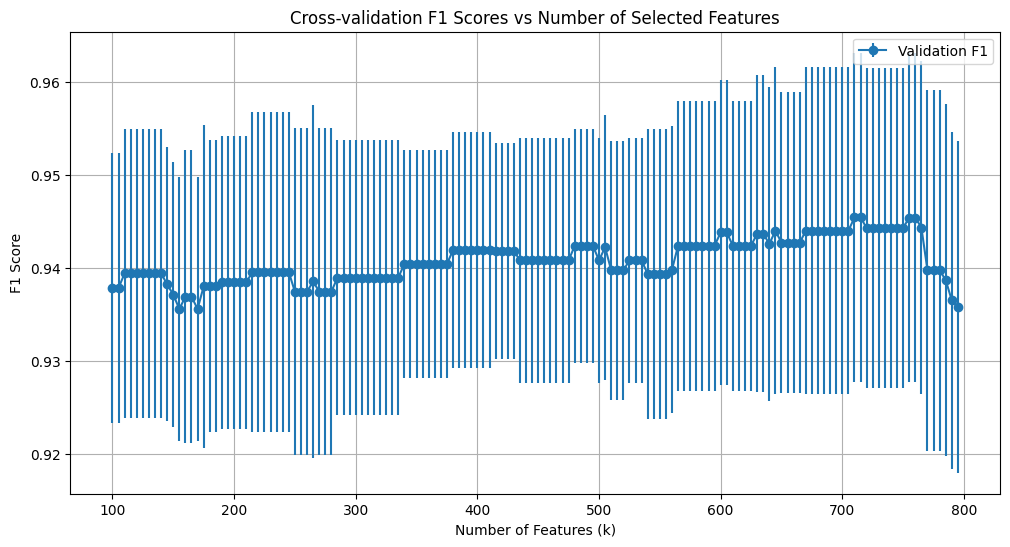

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import BernoulliNB
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import random
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# File paths
train_file = "train.dat"
test_file = "test.dat"

# Load and preprocess training data
def load_data(file_path, has_labels=True):
    with open(file_path, "r") as fr:
        lines = fr.readlines()

    if has_labels:
        labels = [int(l[0]) for l in lines]
        docs = [re.sub(r'[^\w]', ' ', l[1:]).split() for l in lines]
    else:
        labels = None
        docs = [re.sub(r'[^\w]', ' ', l).split() for l in lines]

    features = []
    for doc in docs:
        line = [0] * 100001
        for value in doc:
            line[int(value)] = 1
        features.append(line)

    return np.array(features), np.array(labels) if labels is not None else None

# Load all data
print("Loading training data...")
X_train, y_train = load_data(train_file, has_labels=True)
print("Loading test data...")
X_test, _ = load_data(test_file, has_labels=False)

# Apply VarianceThreshold
print("Removing low variance features...")
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# Print initial distributions
print("\nData Distributions:")
print(f"Training samples: {X_train_selected.shape[0]}")
print(f"Test samples: {X_test_selected.shape[0]}")
train_dist = Counter(y_train)
print(f"\nTraining distribution - Class 0: {train_dist[0]}, Class 1: {train_dist[1]}")

# Define Naïve Bayes classifier
classifier = BernoulliNB()

# Training and evaluation
print("\nTraining and evaluating models...")
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2),
    clone(classifier)
)

param_grid = {
    'selectkbest__k': list(range(100, 800, 5))
}

# Perform grid search with fixed random state
grid_search = GridSearchCV(
    pipeline, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1
)
grid_search.fit(X_train_selected, y_train)

# Print cross-validation results
print("\n=== Cross-validation F1 Scores for All k Values ===")
cv_results = grid_search.cv_results_

for k, val_score, val_std in zip(cv_results['param_selectkbest__k'], 
                                cv_results['mean_test_score'], 
                                cv_results['std_test_score']):
    print(f"k = {k:2d}: Validation F1 = {val_score:.4f} (±{val_std:.4f})")

# Create sorted version by validation F1 score
print("\n=== Scores Sorted by Validation F1 (Best to Worst) ===")
sorted_results = sorted(zip(cv_results['param_selectkbest__k'],
                          cv_results['mean_test_score'],
                          cv_results['std_test_score']),
                       key=lambda x: x[1],
                       reverse=True)

for k, val_score, val_std in sorted_results:
    print(f"k = {k:2d}: Validation F1 = {val_score:.4f} (±{val_std:.4f})")

# Get best k and score
best_k = grid_search.best_params_['selectkbest__k']
best_val_f1 = grid_search.best_score_

print(f"\nBest k value based on cross-validation: {best_k}")
print(f"Best validation F1 score: {best_val_f1:.4f}")

# Train final model with best k
final_pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2, k=best_k),
    clone(classifier)
)
final_pipeline.fit(X_train_selected, y_train)

# Make predictions on test data
print("\nMaking predictions on test data...")
final_predictions = final_pipeline.predict(X_test_selected)

# Save predictions
result_file = 'naive_bayes_results.dat'
with open(result_file, 'w') as output:
    for pred in final_predictions:
        output.write(str(pred) + "\n")
print(f"Predictions saved to {result_file}")

# Plot validation scores
plt.figure(figsize=(12, 6))
k_values = cv_results['param_selectkbest__k']

plt.errorbar(k_values,
             cv_results['mean_test_score'],
             yerr=cv_results['std_test_score'],
             fmt='o-', label='Validation F1')

plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.title('Cross-validation F1 Scores vs Number of Selected Features')
plt.legend()
plt.grid(True)
plt.savefig('naive_bayes_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()


# Another Exploration: Decision Tree with SelectKBest

Loading training data...
Loading test data...
Removing low variance features...

Data Distributions:
Training samples: 800
Test samples: 350

Training distribution - Class 0: 722, Class 1: 78

Training and evaluating models...

=== Cross-validation F1 Scores for All k Values ===
k = 100: Validation F1 = 0.8727 (±0.0424)
k = 105: Validation F1 = 0.8766 (±0.0374)
k = 110: Validation F1 = 0.8654 (±0.0314)
k = 115: Validation F1 = 0.8737 (±0.0217)
k = 120: Validation F1 = 0.8786 (±0.0196)
k = 125: Validation F1 = 0.8596 (±0.0261)
k = 130: Validation F1 = 0.8599 (±0.0328)
k = 135: Validation F1 = 0.8713 (±0.0170)
k = 140: Validation F1 = 0.8583 (±0.0347)
k = 145: Validation F1 = 0.8069 (±0.1186)
k = 150: Validation F1 = 0.8131 (±0.1054)
k = 155: Validation F1 = 0.7903 (±0.1142)
k = 160: Validation F1 = 0.7689 (±0.1090)
k = 165: Validation F1 = 0.7907 (±0.1050)
k = 170: Validation F1 = 0.7727 (±0.1107)
k = 175: Validation F1 = 0.7688 (±0.1003)
k = 180: Validation F1 = 0.7569 (±0.1090)
k = 18

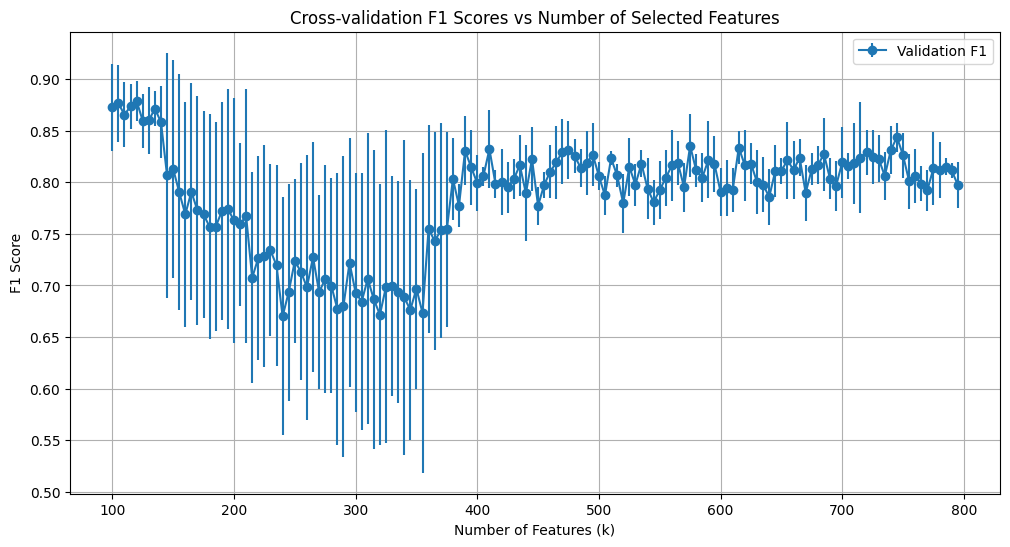

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
import random
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# File paths
train_file = "train.dat"
test_file = "test.dat"

# Load and preprocess training data
def load_data(file_path, has_labels=True):
    with open(file_path, "r") as fr:
        lines = fr.readlines()

    if has_labels:
        labels = [int(l[0]) for l in lines]
        docs = [re.sub(r'[^\w]', ' ', l[1:]).split() for l in lines]
    else:
        labels = None
        docs = [re.sub(r'[^\w]', ' ', l).split() for l in lines]

    features = []
    for doc in docs:
        line = [0] * 100001
        for value in doc:
            line[int(value)] = 1
        features.append(line)

    return np.array(features), np.array(labels) if labels is not None else None

# Load all data
print("Loading training data...")
X_train, y_train = load_data(train_file, has_labels=True)
print("Loading test data...")
X_test, _ = load_data(test_file, has_labels=False)

# Apply VarianceThreshold
print("Removing low variance features...")
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# Print initial distributions
print("\nData Distributions:")
print(f"Training samples: {X_train_selected.shape[0]}")
print(f"Test samples: {X_test_selected.shape[0]}")
train_dist = Counter(y_train)
print(f"\nTraining distribution - Class 0: {train_dist[0]}, Class 1: {train_dist[1]}")

# Define Decision Tree classifier
classifier = DecisionTreeClassifier(random_state=42)

# Training and evaluation
print("\nTraining and evaluating models...")
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2),
    clone(classifier)
)

param_grid = {
    'selectkbest__k': list(range(100, 800, 5))
}

# Perform grid search with fixed random state
grid_search = GridSearchCV(
    pipeline, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1
)
grid_search.fit(X_train_selected, y_train)

# Print cross-validation results
print("\n=== Cross-validation F1 Scores for All k Values ===")
cv_results = grid_search.cv_results_

for k, val_score, val_std in zip(
        cv_results['param_selectkbest__k'], 
        cv_results['mean_test_score'], 
        cv_results['std_test_score']):
    print(f"k = {k:2d}: Validation F1 = {val_score:.4f} (±{val_std:.4f})")

# Get best parameters
best_k = grid_search.best_params_['selectkbest__k']
best_val_f1 = grid_search.best_score_

print(f"\nBest k value: {best_k}")
print(f"Best validation F1 score: {best_val_f1:.4f}")

# Train final model with best parameters
final_pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2, k=best_k),
    DecisionTreeClassifier(random_state=42)
)
final_pipeline.fit(X_train_selected, y_train)

# Make predictions on test data
print("\nMaking predictions on test data...")
final_predictions = final_pipeline.predict(X_test_selected)

# Save predictions
result_file = 'decision_tree_results.dat'
with open(result_file, 'w') as output:
    for pred in final_predictions:
        output.write(str(pred) + "\n")
print(f"Predictions saved to {result_file}")

# Plot validation scores
plt.figure(figsize=(12, 6))
k_values = cv_results['param_selectkbest__k']
mean_scores = cv_results['mean_test_score']

plt.errorbar(k_values, mean_scores, yerr=cv_results['std_test_score'], fmt='o-', label='Validation F1')
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.title('Cross-validation F1 Scores vs Number of Selected Features')
plt.legend()
plt.grid(True)
plt.savefig('decision_tree_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()


# Final Model Training: Naïve Bayes (Bernoulli) with SelectKBest (k=613)

In [3]:
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import BernoulliNB
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import random
import time

np.random.seed(42)
random.seed(42)

def load_data(file_path, has_labels=True):
    with open(file_path, "r") as fr:
        lines = fr.readlines()
    
    if has_labels:
        labels = [int(l[0]) for l in lines]
        docs = [re.sub(r'[^\w]', ' ', l[1:]).split() for l in lines]
    else:
        labels = None
        docs = [re.sub(r'[^\w]', ' ', l).split() for l in lines]
    
    features = []
    for doc in docs:
        line = [0] * 100001
        for value in doc:
            line[int(value)] = 1
        features.append(line)
    
    return np.array(features), np.array(labels) if labels is not None else None

print("Loading data...")
start_time = time.time()
X_train, y_train = load_data("train.dat", has_labels=True)
X_test, _ = load_data("test.dat", has_labels=False)
print(f"Data loaded in {time.time() - start_time:.2f} seconds.")

print("Applying VarianceThreshold...")
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

print("\nData Summary:")
print(f"Training Samples: {X_train_selected.shape[0]}, Features: {X_train_selected.shape[1]}")
print(f"Test Samples: {X_test_selected.shape[0]}")
train_dist = Counter(y_train)
print(f"Class Distribution - Class 0: {train_dist[0]}, Class 1: {train_dist[1]}")

classifier = BernoulliNB()
pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2),
    clone(classifier)
)

param_grid = {'selectkbest__k': list(range(613, 614))}
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)

print("\nPerforming Grid Search...")
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
print(f"Grid search completed in {time.time() - start_time:.2f} seconds.")

print("\n=== Cross-Validation Results ===")
cv_results = grid_search.cv_results_
for k, mean_score, std_score in zip(cv_results['param_selectkbest__k'], 
                                    cv_results['mean_test_score'], 
                                    cv_results['std_test_score']):
    print(f"k = {k}: F1 Score = {mean_score:.4f} (±{std_score:.4f})")

best_k = grid_search.best_params_['selectkbest__k']
best_f1 = grid_search.best_score_
print(f"\nBest k: {best_k}, Best F1 Score: {best_f1:.4f}")

print("\nTraining final model...")
final_pipeline = make_pipeline(
    RandomUnderSampler(random_state=42),
    SelectKBest(chi2, k=best_k),
    clone(classifier)
)
final_pipeline.fit(X_train_selected, y_train)

y_train_pred = final_pipeline.predict(X_train_selected)
print("\n=== Training Performance ===")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nPredicting on test data...")
test_predictions = final_pipeline.predict(X_test_selected)

with open('result_613.dat', 'w') as output:
    for pred in test_predictions:
        output.write(f"{pred}\n")
print("Predictions saved to result_613.dat.")

def process_dat_file(file_path):
    count_0 = 0
    count_1 = 0
    line_numbers_of_1s = []

    with open(file_path, 'r') as file:
        for line_num, line in enumerate(file, start=1):
            value = line.strip()
            if value == '0':
                count_0 += 1
            elif value == '1':
                count_1 += 1
                line_numbers_of_1s.append(line_num)

    return count_0, count_1, line_numbers_of_1s


file_path = 'result_613.dat'
count_0, count_1, line_numbers_of_1s = process_dat_file(file_path)
print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")
print(f"Line numbers of 1s: {line_numbers_of_1s}")



Loading data...
Data loaded in 3.85 seconds.
Applying VarianceThreshold...

Data Summary:
Training Samples: 800, Features: 30571
Test Samples: 350
Class Distribution - Class 0: 722, Class 1: 78

Performing Grid Search...
Grid search completed in 1.35 seconds.

=== Cross-Validation Results ===
k = 613: F1 Score = 0.9424 (±0.0156)

Best k: 613, Best F1 Score: 0.9424

Training final model...

=== Training Performance ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       722
           1       0.74      0.86      0.80        78

    accuracy                           0.96       800
   macro avg       0.86      0.91      0.89       800
weighted avg       0.96      0.96      0.96       800

Confusion Matrix:
[[699  23]
 [ 11  67]]

Predicting on test data...
Predictions saved to result_613.dat.
Number of 0s: 315
Number of 1s: 35
Line numbers of 1s: [1, 10, 26, 54, 56, 62, 67, 83, 84, 86, 99, 100, 115, 119, 121, 132, 147, 149, 161, 163, 2